In [923]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
#slope detection
from scipy.stats import linregress
#Outlier model
from sklearn.ensemble import IsolationForest
#Preprocessing model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#Feature choosing model
from sklearn.decomposition import PCA
#K means models
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from collections import Counter
from tabulate import tabulate


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [557]:
df = pd.read_csv(r"C:\Users\ajhay\Downloads\DA_Practice\data.csv", encoding="ISO-8859-1")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [558]:
#Preliminary Analysis

In [559]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [560]:
#Summary Statistics

In [561]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [564]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [568]:
#Data Cleaning

In [569]:
miss_data = df.isnull().sum()
miss_data_perc = (miss_data[miss_data > 0]/df.shape[0])*100
miss_data_perc

Description     0.268311
CustomerID     24.926694
dtype: float64

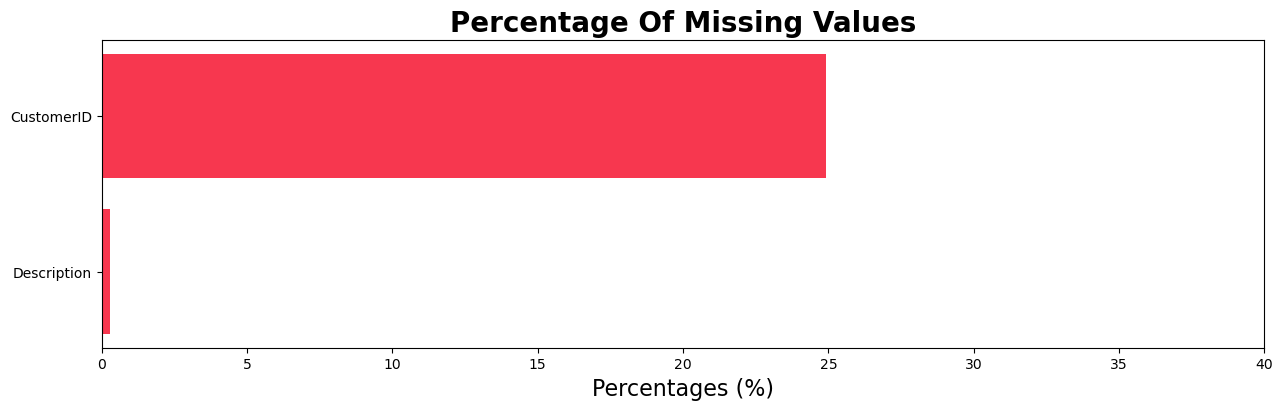

In [570]:
fix,ax = plt.subplots(figsize=(15,4))
ax.barh(miss_data_perc.index, miss_data_perc, color='#F7374F')
ax.set_xlim([0,40])
plt.title('Percentage Of Missing Values', fontweight='bold', fontsize=20)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [572]:
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [574]:
df = df.dropna(subset=['CustomerID','Description'])

In [576]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [577]:
#All the missing values have been handled

In [580]:
#Handling of duplicated values

In [582]:
dup_row = df[df.duplicated(keep=False)]

dup_row_sort = dup_row.sort_values(by = ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])
dup_row_sort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


In [585]:
df.drop_duplicates(inplace=True)

In [587]:
df.duplicated().sum()

0

In [588]:
#The duplicates have been handled

In [589]:
# Treat Cancelled Orders

In [591]:
df['Transaction Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'),'Cancelled','Completed')

In [592]:
cancell_trans = df[df['Transaction Status'] == 'Cancelled']
cancell_trans.describe().drop('CustomerID',axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


In [594]:
cancell_trans_perc = (cancell_trans.shape[0]/df.shape[0])*100
round(cancell_trans_perc,2)

2.21

In [595]:
df['StockCode'].nunique()

3684

In [599]:
top_10_stock = (df['StockCode'].value_counts(normalize = True).head(10))*100

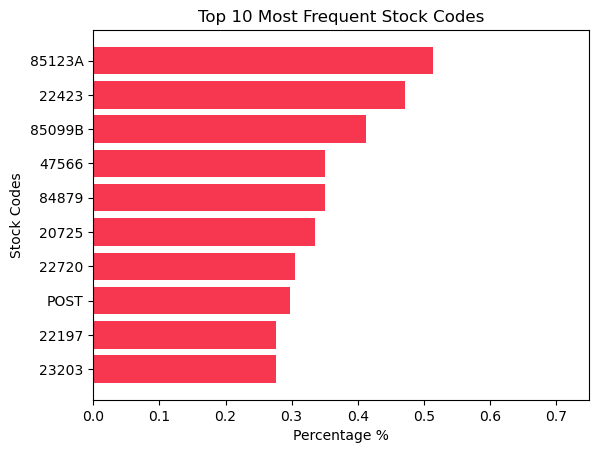

In [600]:
fig, ax = plt.subplots()
ax.barh(top_10_stock.iloc[::-1].index, top_10_stock.iloc[::-1],color='#F7374F')
ax.set_xlim(0,0.75)
plt.xlabel('Percentage %')
plt.ylabel('Stock Codes')
plt.title('Top 10 Most Frequent Stock Codes')
plt.show()

In [602]:
#Cleaning Stock Code Column

In [606]:
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

In [607]:
numeric_char_counts

5    3676
0       7
1       1
Name: count, dtype: int64

In [610]:
anoma_stock_codes = [code for code in unique_stock_codes if(sum(c.isdigit() for c in str(code)) in (0,1))]

In [612]:
for x in anoma_stock_codes:
    print(x)

POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [614]:
percent_anomal = ((df['StockCode'].isin(anoma_stock_codes)).sum()/len(df))*100
round(percent_anomal,2)

0.48

In [617]:
df = df[~df['StockCode'].isin(anoma_stock_codes)]

In [619]:
#Cleaning Description Column

In [621]:
description_counts = df['Description'].value_counts()

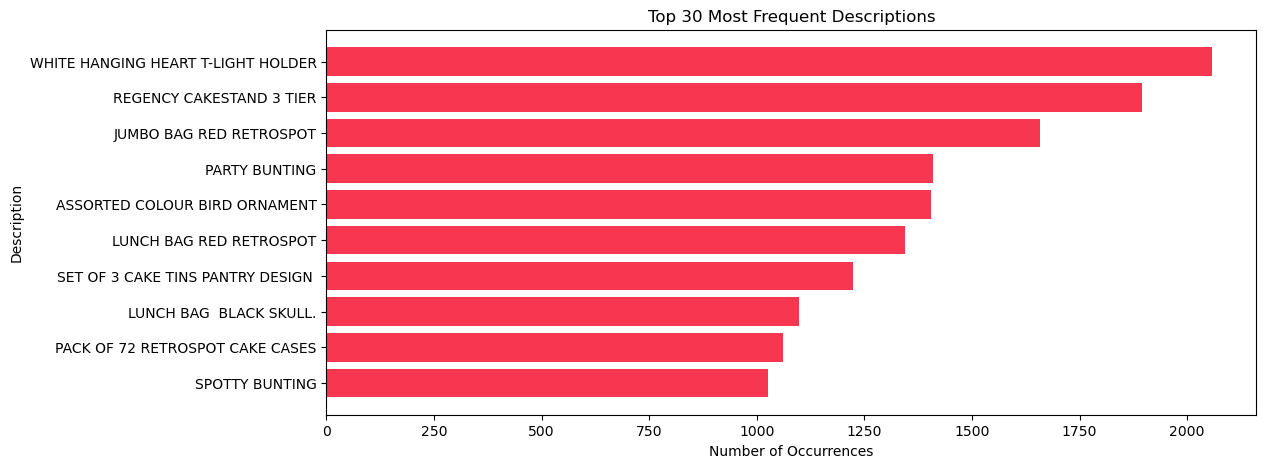

In [623]:
desc_count = description_counts.head(10)

fig, ax = plt.subplots(figsize = (12,5))
ax.barh(desc_count.iloc[::-1].index, desc_count.iloc[::-1],color='#F7374F')
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')
plt.show()

In [626]:
low_case_char = df['Description'].unique()
low_case_char = [code for code in low_case_char if any(char.islower() for char in code)]

In [627]:
for code in low_case_char:
    print(code)

BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [629]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

service_perc = df[df['Description'].isin(service_related_descriptions)].shape[0]/df.shape[0]*100
round(service_perc,2)

0.02

In [631]:
df = df[~df['Description'].isin(service_related_descriptions)]
df['Description'] = df['Description'].str.upper()

In [634]:
# Treat Prices

In [635]:
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [637]:
df[df['UnitPrice'] == 0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [640]:
df = df[df['UnitPrice'] > 0]

In [642]:
df.reset_index(drop=True, inplace = True)

In [644]:
#Feature Engineering Phase

In [647]:
#RFM (RECENCY, FREQUENCY, MONETARY) Analysis

In [649]:
#Days Since last purchase

In [651]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [653]:
df['InvoiceDay'] = df['InvoiceDate'].dt.date

customer_recent_date = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()
customer_recent_date.head(5)

,CustomerID,InvoiceDay
0,12346.0,2011-01-18
1,12347.0,2011-12-07
2,12348.0,2011-09-25
3,12349.0,2011-11-21
4,12350.0,2011-02-02


In [654]:
most_recent_date = df['InvoiceDay'].max()

In [655]:
#To find no.of days from the last purchase

In [657]:
customer_recent_date['InvoiceDay'] = pd.to_datetime(customer_recent_date['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

customer_recent_date['Days from last purchase'] = (most_recent_date - customer_recent_date['InvoiceDay']).dt.days

In [661]:
customer_recent_date.drop(columns=['InvoiceDay'], inplace=True)

In [662]:
customer_recent_date.head()

,CustomerID,Days from last purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [664]:
#Frequency Analysis

In [667]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo':'Total_transactions'},inplace=True)

In [668]:
total_products = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products.rename(columns={'Quantity': 'Total_Products'}, inplace = True)

In [671]:
customer_recent_date = pd.merge(customer_recent_date, total_transactions, on ='CustomerID')
customer_recent_date = pd.merge(customer_recent_date, total_products, on ='CustomerID')

In [673]:
customer_recent_date.head()

,CustomerID,Days from last purchase,Total_transactions,Total_Products
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


In [675]:
#Monetary Analysis

In [677]:
df['Total Spent'] = df['Quantity'] * df['UnitPrice']
total_spent = df.groupby('CustomerID')['Total Spent'].sum().reset_index()

customer_recent_date = pd.merge(customer_recent_date, total_spent, on='CustomerID')

customer_recent_date['Avg_Trans'] = customer_recent_date['Total Spent']/customer_recent_date['Total_transactions']


In [679]:
customer_recent_date.head()

,CustomerID,Days from last purchase,Total_transactions,Total_Products,Total Spent,Avg_Trans
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


In [681]:
#Diversity Of Product

In [683]:
unique_prod_pur = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_prod_pur.rename(columns={'StockCode':'No. Of Unique products'}, inplace=True)

customer_recent_date = pd.merge(customer_recent_date, unique_prod_pur, on = 'CustomerID')

In [685]:
customer_recent_date.head()

,CustomerID,Days from last purchase,Total_transactions,Total_Products,Total Spent,Avg_Trans,No. Of Unique products
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


In [687]:
#Behavioural analysis

In [689]:
df['Day Of Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

In [691]:
#Avg time between purchases

In [693]:
days_between_purchase = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x : (x.diff().dropna()).apply(lambda y : y.days))

In [694]:
avg_days_between_purchase = days_between_purchase.groupby('CustomerID').mean().reset_index()
avg_days_between_purchase.rename(columns={'InvoiceDay':'Avg Days btw Purchase'}, inplace=True)
customer_recent_date = pd.merge(customer_recent_date, avg_days_between_purchase, on='CustomerID')

In [695]:
#Favourite Shopping Day

In [696]:
fav_shopping_day = df.groupby(['CustomerID','Day Of Week']).size().reset_index(name='Count')

fav_shopping_day = fav_shopping_day.loc[fav_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day Of Week']]

customer_recent_date = pd.merge(customer_recent_date, fav_shopping_day, on='CustomerID')

In [697]:
#favourite Shopping Hour

In [698]:
fav_shopping_hour = df.groupby(['CustomerID','Hour']).size().reset_index(name='Count')
fav_shopping_hour = fav_shopping_hour.loc[fav_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID','Hour']]
customer_recent_date = pd.merge(customer_recent_date, fav_shopping_hour, on='CustomerID')

In [699]:
fav_shopping_hourrrrrr = df.groupby(['CustomerID','Hour']).size().reset_index(name='Count')

In [700]:
customer_recent_date.head()

,CustomerID,Days from last purchase,Total_transactions,Total_Products,Total Spent,Avg_Trans,No. Of Unique products,Avg Days btw Purchase,Day Of Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


In [701]:
#Geographic Features

In [702]:
df['Country'].value_counts(normalize = True).head()

Country
United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: proportion, dtype: float64

In [703]:
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='No of transactions')
customer_max_country = customer_country.sort_values('No of transactions', ascending=False).drop_duplicates('CustomerID')

In [704]:
customer_max_country['Is_UK'] = customer_max_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

In [705]:
customer_recent_date = pd.merge(customer_recent_date, customer_max_country, on='CustomerID', how = 'left')

In [706]:
customer_recent_date.rename(columns={'Is_UK':'UK_bin'},inplace=True)

In [707]:
customer_recent_date.head()

,CustomerID,Days from last purchase,Total_transactions,Total_Products,Total Spent,Avg_Trans,No. Of Unique products,Avg Days btw Purchase,Day Of Week,Hour,Country,No of transactions,UK_bin
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,United Kingdom,2,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,Iceland,182,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,Finland,27,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,Italy,72,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,Norway,16,0


In [708]:
customer_recent_date.drop(columns=['Country','No of transactions'], inplace=True)

In [709]:
customer_recent_date['UK_bin'].value_counts()

UK_bin
1    3866
0     416
Name: count, dtype: int64

In [715]:
#Cancellation Analysis

In [722]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

cancelled_transactions = df[df['Transaction Status'] == 'Cancelled']
cancelled_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancelled_frequency.rename(columns = {'InvoiceNo':'Cancellation_Freq'}, inplace = True)

In [729]:
customer_recent_date = pd.merge(customer_recent_date, cancelled_frequency, on = 'CustomerID', how='left')

In [731]:
customer_recent_date['Cancellation_Freq'].fillna(0,inplace=True)

customer_recent_date.head()

,CustomerID,Days from last purchase,Total_transactions,Total_Products,Total Spent,Avg_Trans,No. Of Unique products,Avg Days btw Purchase,Day Of Week,Hour,UK_bin,Cancellation_Freq
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0


In [732]:
#Seasonality trend analysis

In [733]:
#Monthly Spending Mean

In [735]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

monthly_spending = df.groupby(['CustomerID','Year','Month'])['Total Spent'].sum().reset_index()

In [736]:
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total Spent'].agg(['mean','std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean':'Monthly_Spending_Mean','std':'Monthly_Spending_Std'},inplace=True)

In [738]:
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0,inplace=True)

In [741]:
def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope,_,_,_,_ = linregress(x, spend_data)
        return slope
    else:
        return 0

In [743]:
spending_trends =  monthly_spending.groupby('CustomerID')['Total Spent'].apply(calculate_trend).reset_index()

In [745]:
spending_trends.rename(columns = {'Total Spent':'Spending Trend'},inplace=True)

In [748]:
customer_recent_date = pd.merge(customer_recent_date, seasonal_buying_patterns, on='CustomerID')
customer_recent_date = pd.merge(customer_recent_date, spending_trends, on = 'CustomerID')

In [750]:
customer_recent_date['CustomerID'] = customer_recent_date['CustomerID'].astype(str)

In [751]:
customer_recent_dtae = customer_recent_date.convert_dtypes()

In [753]:
#Outliers analysis with IsolationForest Model

In [755]:
model = IsolationForest(contamination =0.05, random_state = 0)
customer_recent_date['Outlier Scores'] = model.fit_predict(customer_recent_date.iloc[:,1:].to_numpy())
customer_recent_date['Is_outlier'] = [1 if x == -1 else 0 for x in customer_recent_date['Outlier Scores']]

In [758]:
outlier_percentage = customer_recent_date['Is_outlier'].value_counts(normalize=True) * 100

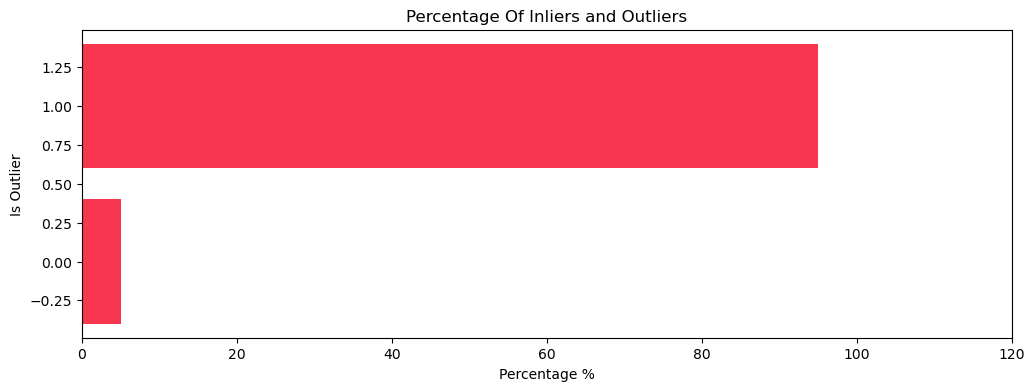

In [761]:
fig, ax = plt.subplots(figsize=(12,4))
ax.barh(outlier_percentage.index, outlier_percentage.iloc[::-1], color='#F7374F')
ax.set_xlim(0, 120)
plt.title('Percentage Of Inliers and Outliers')
plt.ylabel('Is Outlier')
plt.xlabel('Percentage %')
plt.show()

In [763]:
outliers_data =customer_recent_date[customer_recent_date['Is_outlier'] == 1]
customer_recent_date_clean = customer_recent_date[customer_recent_date['Is_outlier'] ==0]
customer_recent_date_clean = customer_recent_date_clean.drop(columns=['Outlier Scores','Is_outlier'])

In [765]:
customer_recent_date_clean.shape[0]

4067

In [766]:
#Correlation Analysis

In [769]:
corr = customer_recent_date_clean.drop(columns =['CustomerID']).corr()
# need only top left to bottom right diagonal

In [772]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

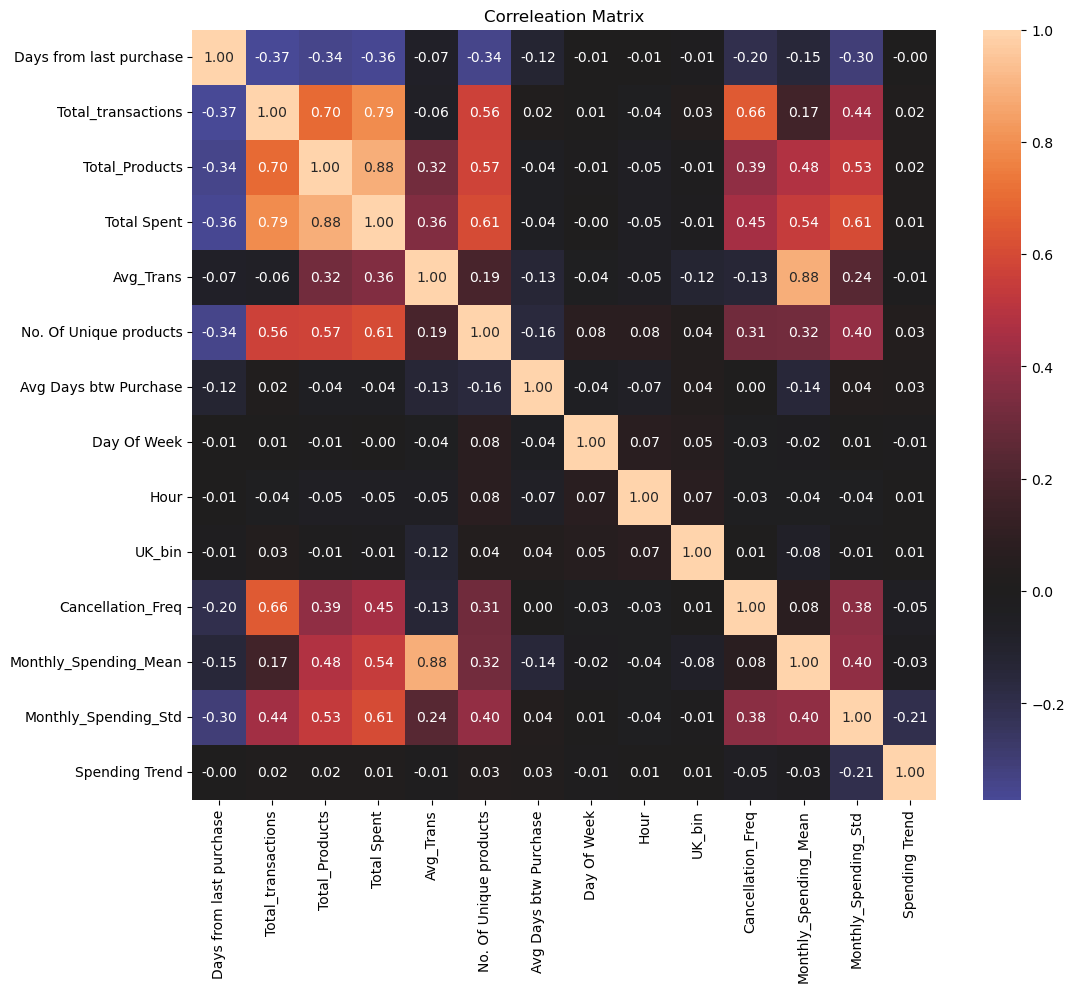

In [774]:
plt.figure(figsize = (12, 10))
sns.heatmap(corr,annot= True, center =0, fmt  = '.2f')
plt.title('Correleation Matrix')
plt.show()

In [776]:
#Feature Scaling

In [777]:
#Need Standard scaling using Principle Component Analysis Method

In [778]:
scaler  = StandardScaler()

columns_to_exclude = ['CustomerID', 'UK_bin', 'Day Of Week']
columns_to_scale = customer_recent_date_clean.columns.difference(columns_to_exclude)
customer_recent_date_scale = customer_recent_date_clean.copy()

customer_recent_date_scale[columns_to_scale] = scaler.fit_transform(customer_recent_date_scale[columns_to_scale])

In [780]:
customer_recent_date_scale.head()

,CustomerID,Days from last purchase,Total_transactions,Total_Products,Total Spent,Avg_Trans,No. Of Unique products,Avg Days btw Purchase,Day Of Week,Hour,UK_bin,Cancellation_Freq,Monthly_Spending_Mean,Monthly_Spending_Std,Spending Trend
0,12346.0,2.345814,-0.476376,-0.783165,-0.846169,-1.326573,-0.903570,-0.412412,1,-1.087816,1,0.363055,-1.349370,-0.721806,0.095944
1,12347.0,-0.903506,0.675480,2.119521,2.486047,1.557208,0.797148,-0.147487,1,0.648165,0,-0.524825,1.018331,1.299868,0.122130
2,12348.0,-0.169139,-0.015634,1.970726,0.265013,0.356304,-0.570096,1.017540,3,2.818140,0,-0.524825,0.032340,0.486654,-0.492939
3,12349.0,-0.742549,-0.706748,-0.039189,0.280715,5.500059,0.280263,-0.412412,0,-1.521811,0,-0.524825,4.255572,-0.721806,0.095944
4,12350.0,2.194916,-0.706748,-0.551706,-0.618558,0.052289,-0.653464,-0.412412,2,1.516155,0,-0.524825,-0.217268,-0.721806,0.095944


In [781]:
#Dimensionality Reduction analysis

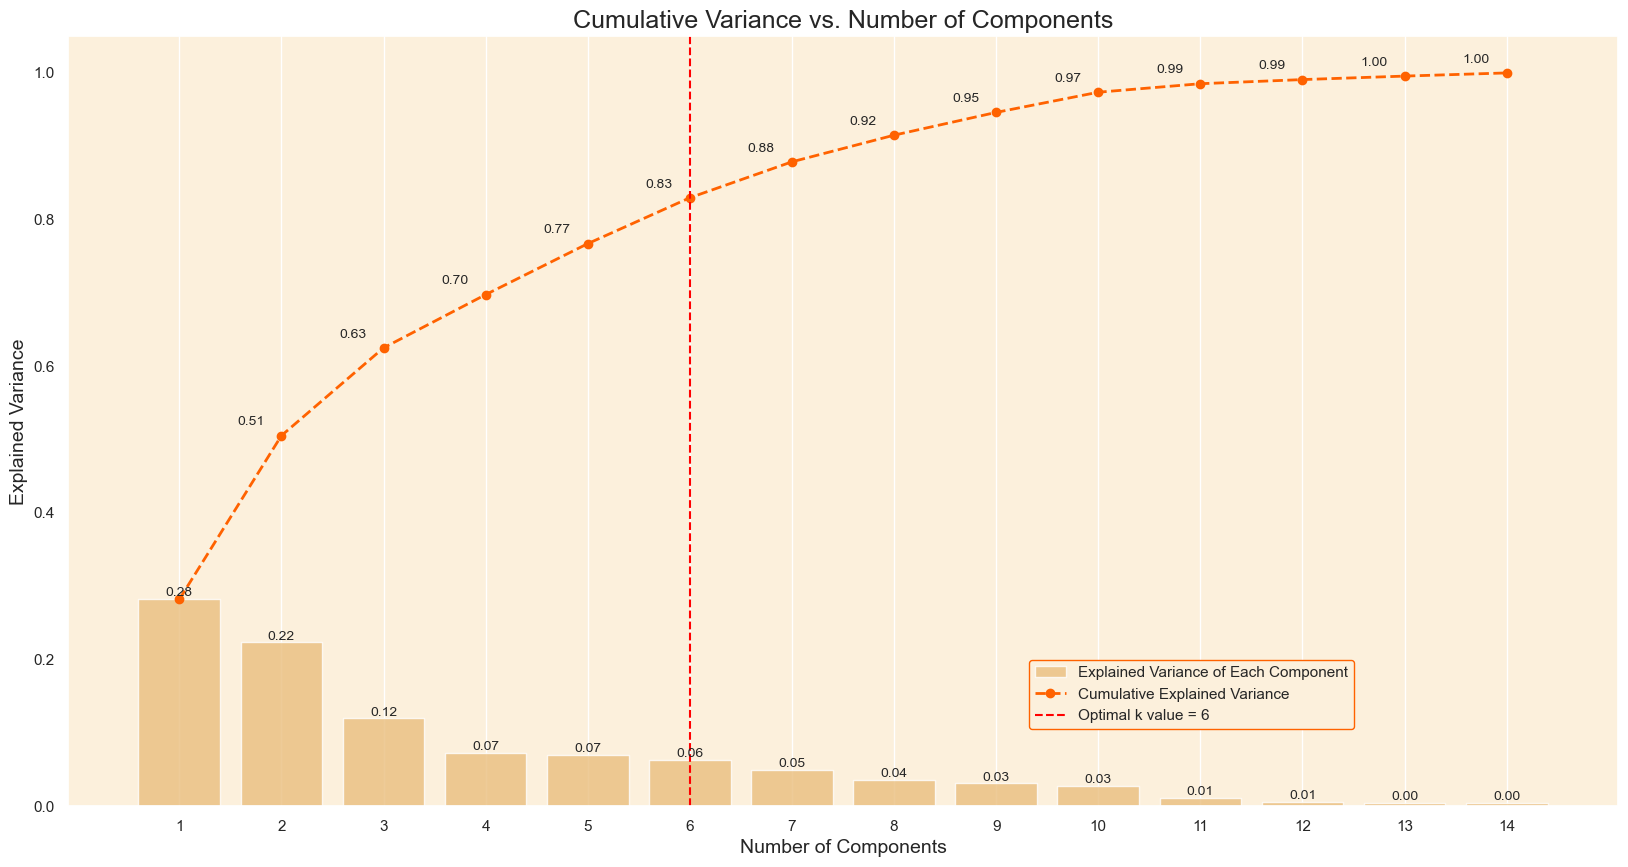

In [782]:
customer_recent_date_scale.set_index('CustomerID', inplace = True)
pca = PCA().fit(customer_recent_date_scale)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

optimal_k =  6

sns.set(rc = {'axes.facecolor':'#fcf0dc'}, style='darkgrid')

plt.figure(figsize=(20,10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [793]:
pca = PCA(n_components = 6)

customer_data_pca = pca.fit_transform(customer_recent_date_scale)

customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

customer_data_pca.index = customer_recent_date_scale.index

In [795]:
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.509745,-1.566670,-1.073902,-0.118270,-0.511208,-2.122837
12347.0,3.621891,-1.574894,1.277238,-0.337374,0.271380,0.904276
12348.0,0.812703,0.518471,0.223956,-0.363387,-0.463050,2.611860
12349.0,2.057020,-2.904855,6.093818,0.842438,1.255051,-0.363360
12350.0,-1.958241,-0.481641,0.781534,-1.287126,-0.833559,0.077428


In [797]:
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:#F7374F' if i in top3 else '' for i in column.index]

#new dataframe for PCA component
pc_df = pd.DataFrame(pca.components_.T, columns=['PC'+str(i+1) for i in range(pca.n_components_)], index=customer_recent_date_scale.columns)

pc_df.style.apply(highlight_top3, axis =0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days from last purchase,-0.228003,-0.004416,0.145840,-0.117388,-0.200803,-0.444506
Total_transactions,0.380652,0.004240,-0.339860,-0.080712,0.023668,-0.115041
Total_Products,0.420692,-0.009435,-0.007046,-0.038749,0.076782,-0.050539
Total Spent,0.448906,-0.007329,-0.006308,-0.021459,0.060267,-0.060056
Avg_Trans,0.194406,-0.034386,0.630286,0.068193,0.090441,0.055901
No. Of Unique products,0.342439,0.050763,-0.049035,-0.273632,-0.029965,0.051740
Avg Days btw Purchase,-0.033133,-0.030800,-0.203684,0.562871,0.438808,0.430748
Day Of Week,0.007111,0.995278,0.027609,0.061336,0.037622,-0.035908
Hour,-0.019995,0.057420,-0.013450,-0.520207,-0.275142,0.723739
UK_bin,-0.001877,0.008348,-0.021586,-0.010548,-0.001615,0.017560


In [811]:
#Elbow Method for clustering

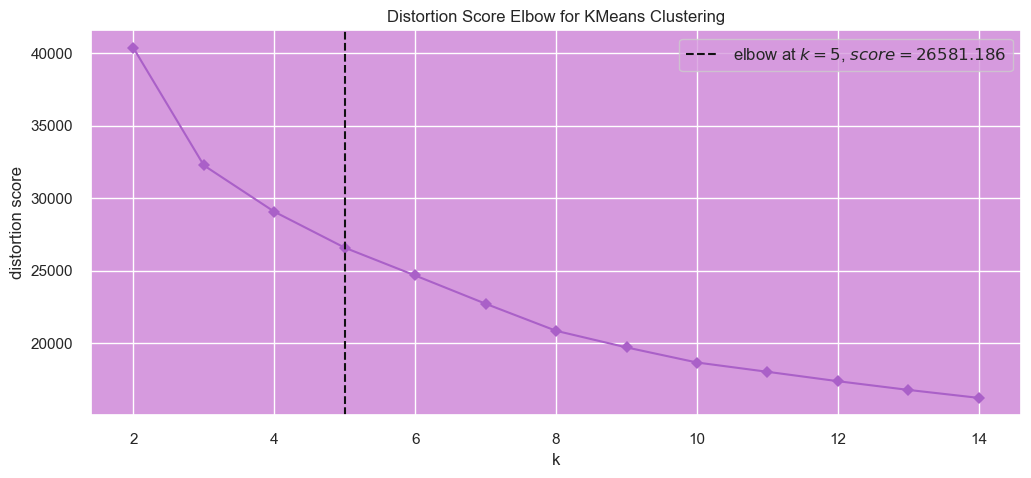

In [823]:
sns.set(style = 'darkgrid', rc={'axes.facecolor':'#D69ADE'})

sns.set_palette(['#AA60C8'])

#Cluster model instantiate
km = KMeans(init = 'k-means++', n_init = 10, max_iter=100, random_state = 0)

fig,ax = plt.subplots(figsize=(12, 5))

visual =  KElbowVisualizer(km, k=(2,15), timings = False, ax=ax)
visual.fit(customer_data_pca)
visual.show();

In [825]:
#Silhouette Method

In [850]:
def silhouette_analysis(df, start_k, stop_k, figsize = (15,16)):
    plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(stop_k - start_k + 1,2)
    first_plot = plt.subplot(grid[0,:])
    #store avg silhouette scores
    silhouette_scores = []

    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)
        
    best_k = start_k + silhouette_scores.index(max(silhouette_scores))
#first graph plot
    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
         horizontalalignment='left', bbox=dict(facecolor='#D69ADE', edgecolor='#3E3F5B', boxstyle='round, pad=0.5'))

#second grpah plot
    colors = sns.color_palette("bright")
    for i in range(start_k, stop_k+1):
        row_idx, col_idx = divmod(i - start_k,2)
        ax = plt.subplot(grid[row_idx+1, col_idx])
        Visual = SilhouetteVisualizer(km, colors = colors, ax=ax)
        Visual.fit(df)
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
        ha='right', transform=ax.transAxes, color='red')

    plt.tight_layout()
    plt.show()

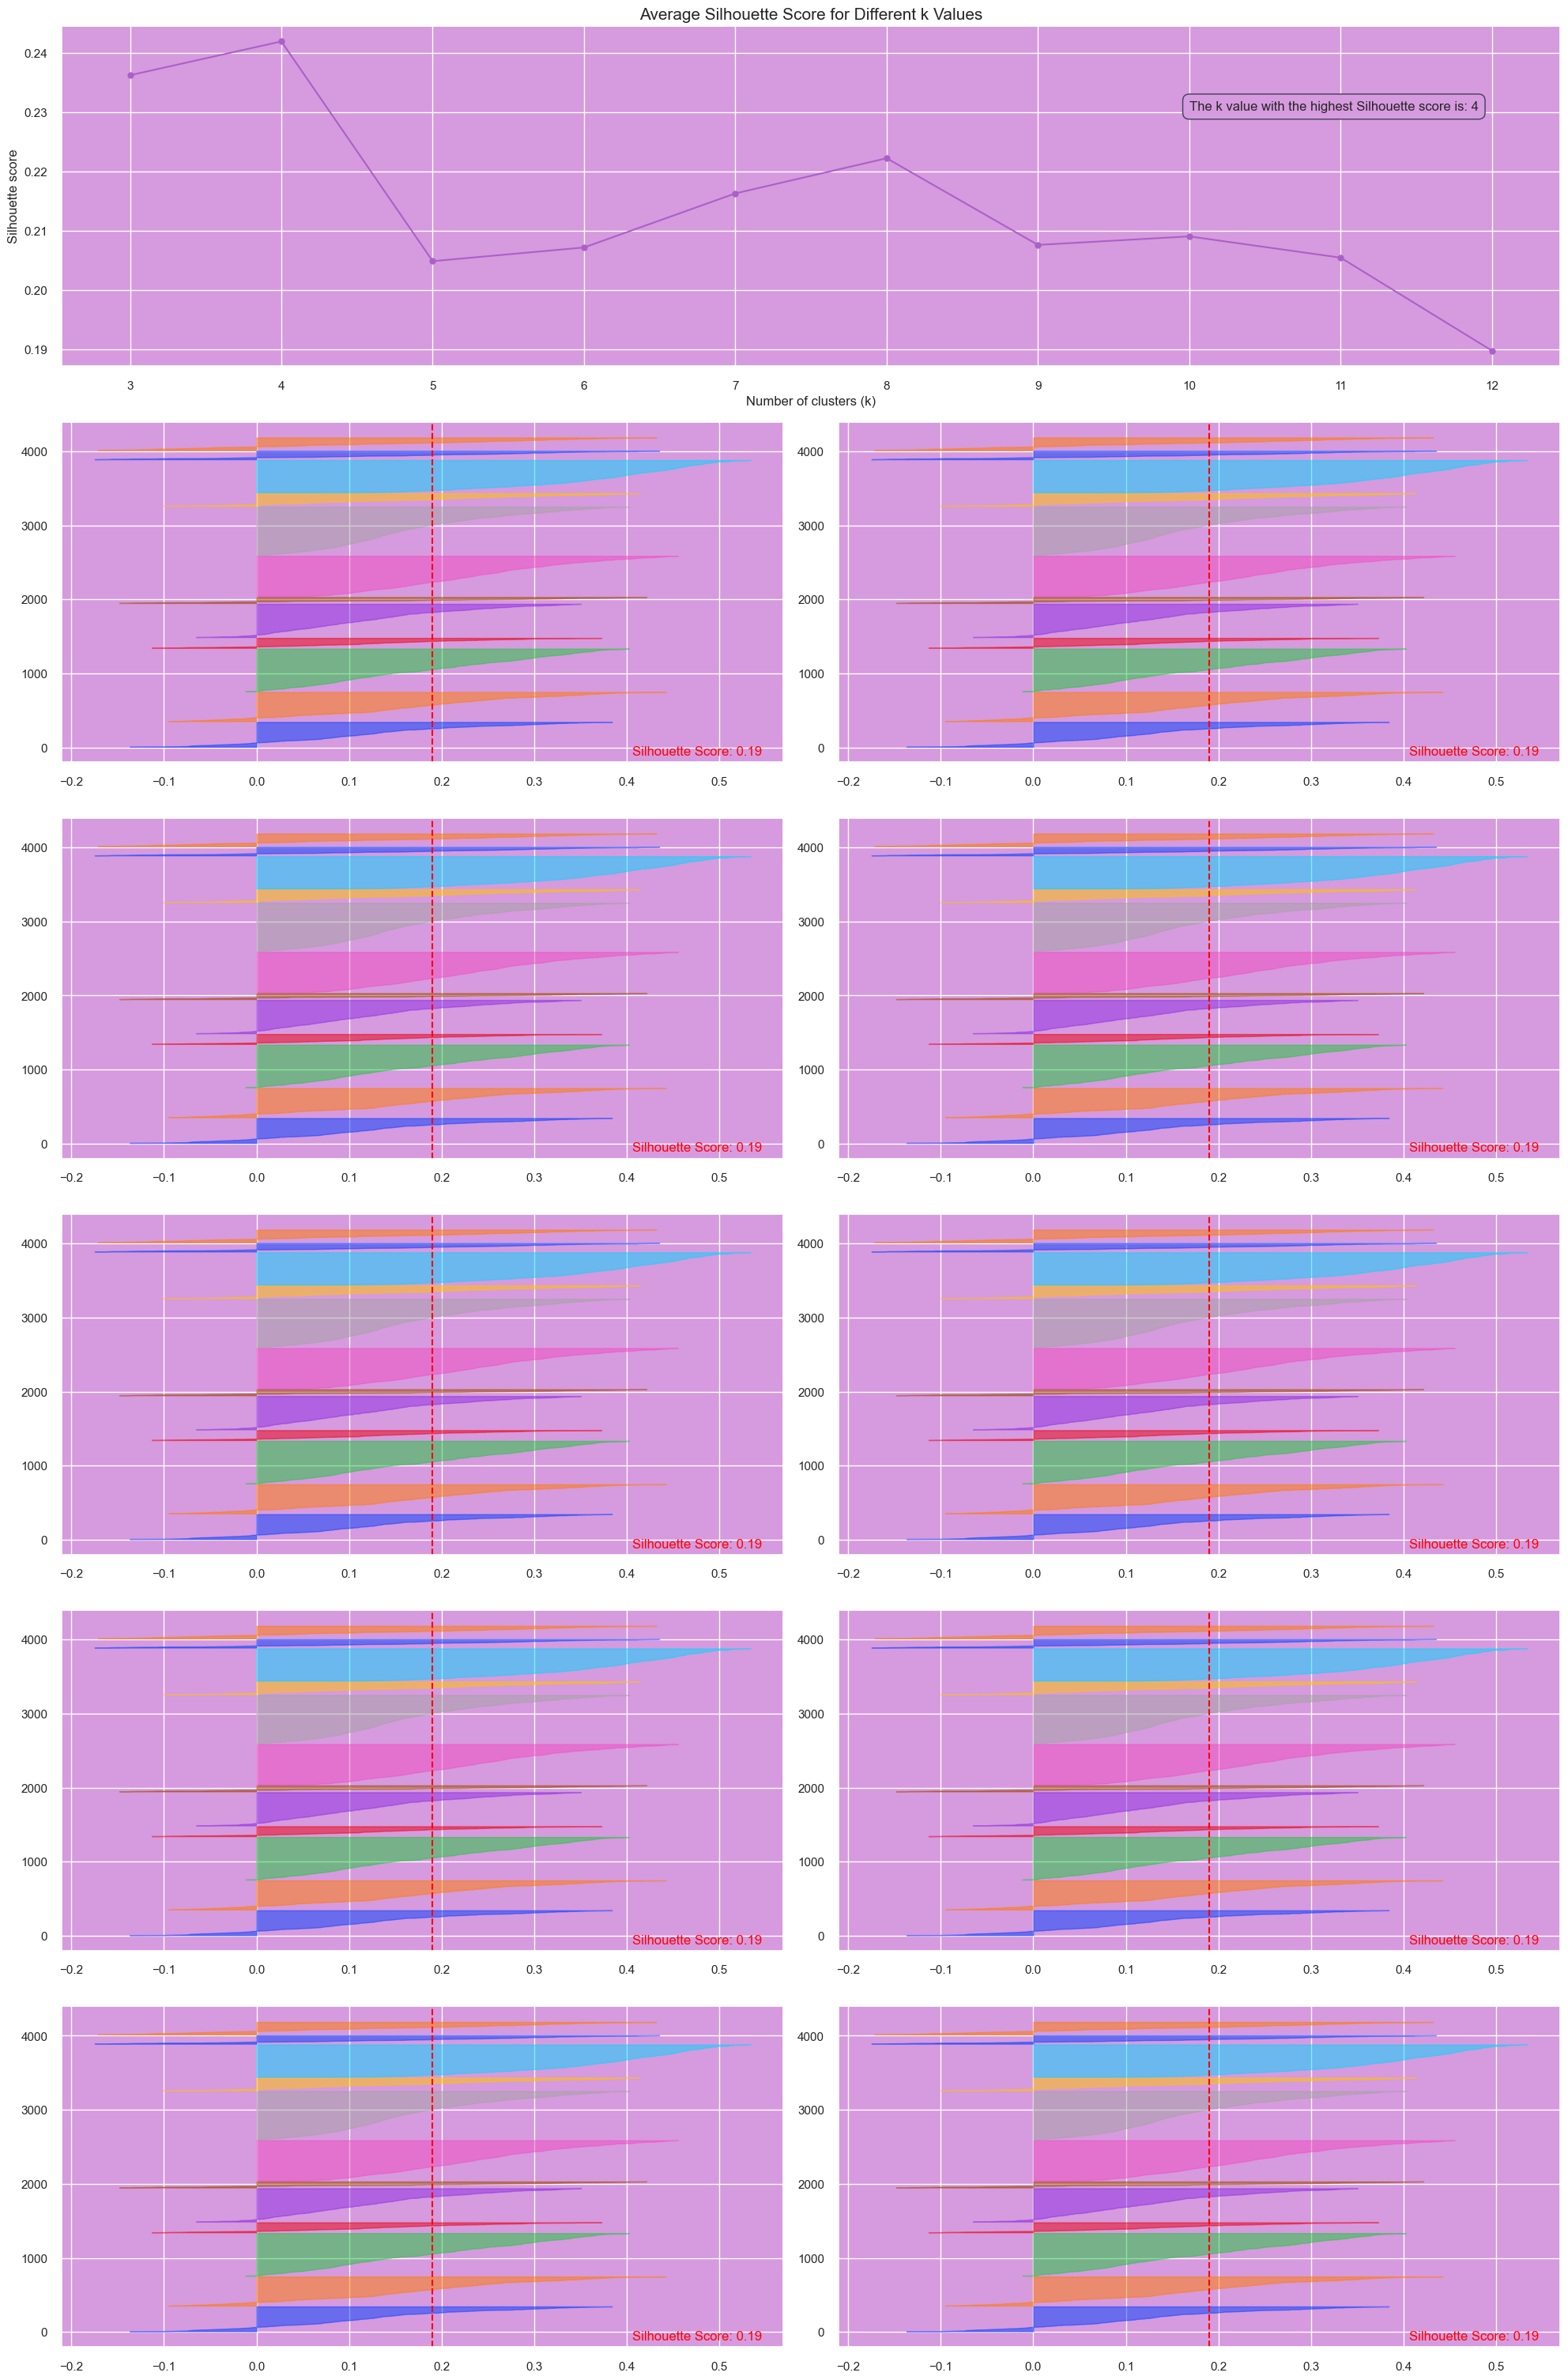

In [852]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

In [854]:
#Cluster Evaluation

In [863]:
kmeans = KMeans(n_clusters =3, init='k-means++', n_init =10, max_iter=100, random_state =0)
kmeans.fit(customer_data_pca)

#Get the frequency
cluster_frequencies = Counter(kmeans.labels_)

label_mapping = {label: new_label for new_label, (label, _) in enumerate(cluster_frequencies.most_common())}

label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

customer_recent_date_clean['cluster'] = new_labels

customer_data_pca['cluster'] = new_labels

In [865]:
customer_recent_date_clean.head()

,CustomerID,Days from last purchase,Total_transactions,Total_Products,Total Spent,Avg_Trans,No. Of Unique products,Avg Days btw Purchase,Day Of Week,Hour,UK_bin,Cancellation_Freq,Monthly_Spending_Mean,Monthly_Spending_Std,Spending Trend,cluster
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.000000,0.000000,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,615.714286,341.070789,4.486071,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,359.310000,203.875689,-100.884000,2
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,1457.550000,0.000000,0.000000,1
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,294.400000,0.000000,0.000000,1


In [867]:
#3D Visualization of Top PCs

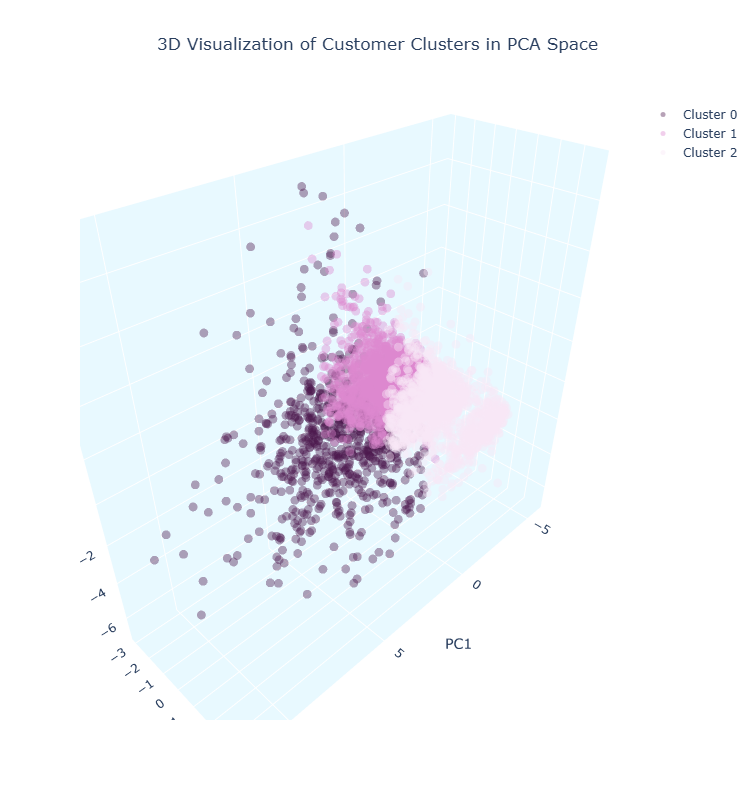

In [881]:
colors = ['#4B164C', '#DD88CF', '#F8E7F6']

cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

fig = go.Figure()


fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#E8F9FF", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#E8F9FF", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#E8F9FF", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

fig.show()

In [871]:
#Cluster Distribution Visual

In [913]:
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize = True)*100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by = 'Cluster', inplace= True)

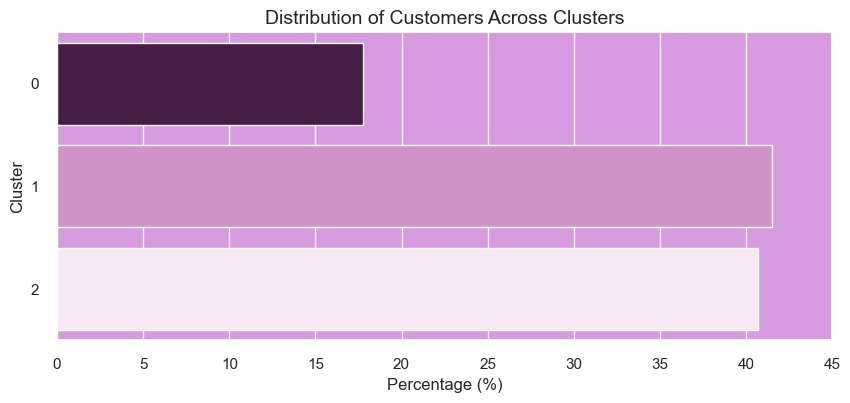

,Cluster,Percentage
2,0,17.777231
0,1,41.504795
1,2,40.717974


In [917]:
plt.figure(figsize=(10,4))
sns.barplot(x = 'Percentage', y='Cluster', data=cluster_percentage, orient='h', palette = colors)



plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

plt.show()
cluster_percentage

In [919]:
#Evaluation Metrics

In [925]:
num_observations = len(customer_data_pca)

X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23630214013190726 |
| Calinski Harabasz Score | 1267.8882193019206  |
|  Davies Bouldin Score   | 1.3791294032858625  |
+-------------------------+---------------------+


In [931]:
#Silhouette Score is not ideal but still its ok
#CH score is high and good to define the quality of clusters
#DB score is bit high but shows decent separation

In [933]:
#Radar and histogram chart approach

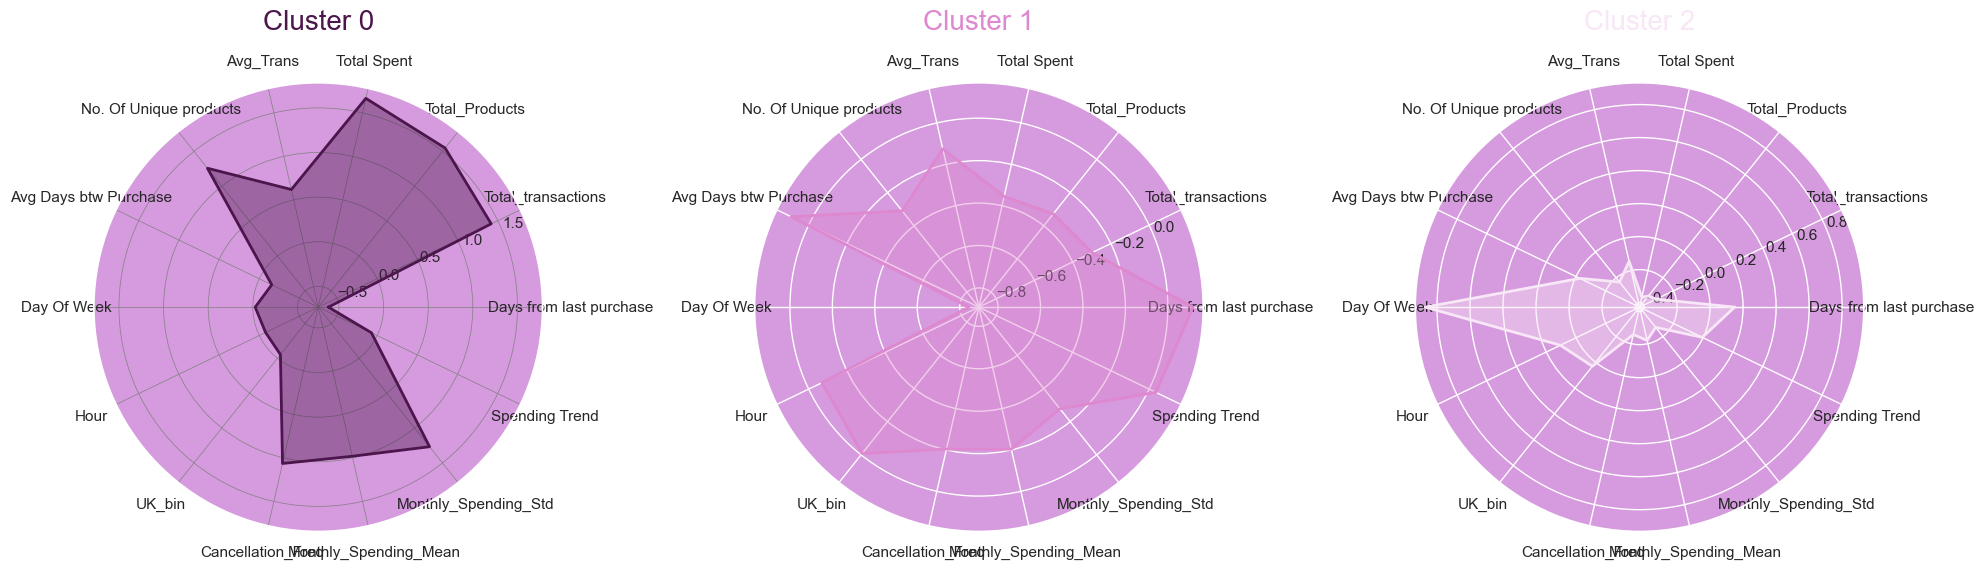

In [935]:
df_customer = customer_recent_date_clean.set_index('CustomerID')

scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))


df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

cluster_centroids = df_customer_standardized.groupby('cluster').mean()


def create_radar_chart(ax, angles, data, color, cluster):

    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    

    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)


labels=np.array(cluster_centroids.columns)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()


labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]


fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1] 
    create_radar_chart(ax[i], angles, data, color, i)


ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])


ax[0].grid(color='grey', linewidth=0.5)


plt.tight_layout()
plt.show()

In [937]:
#Histogram Chart

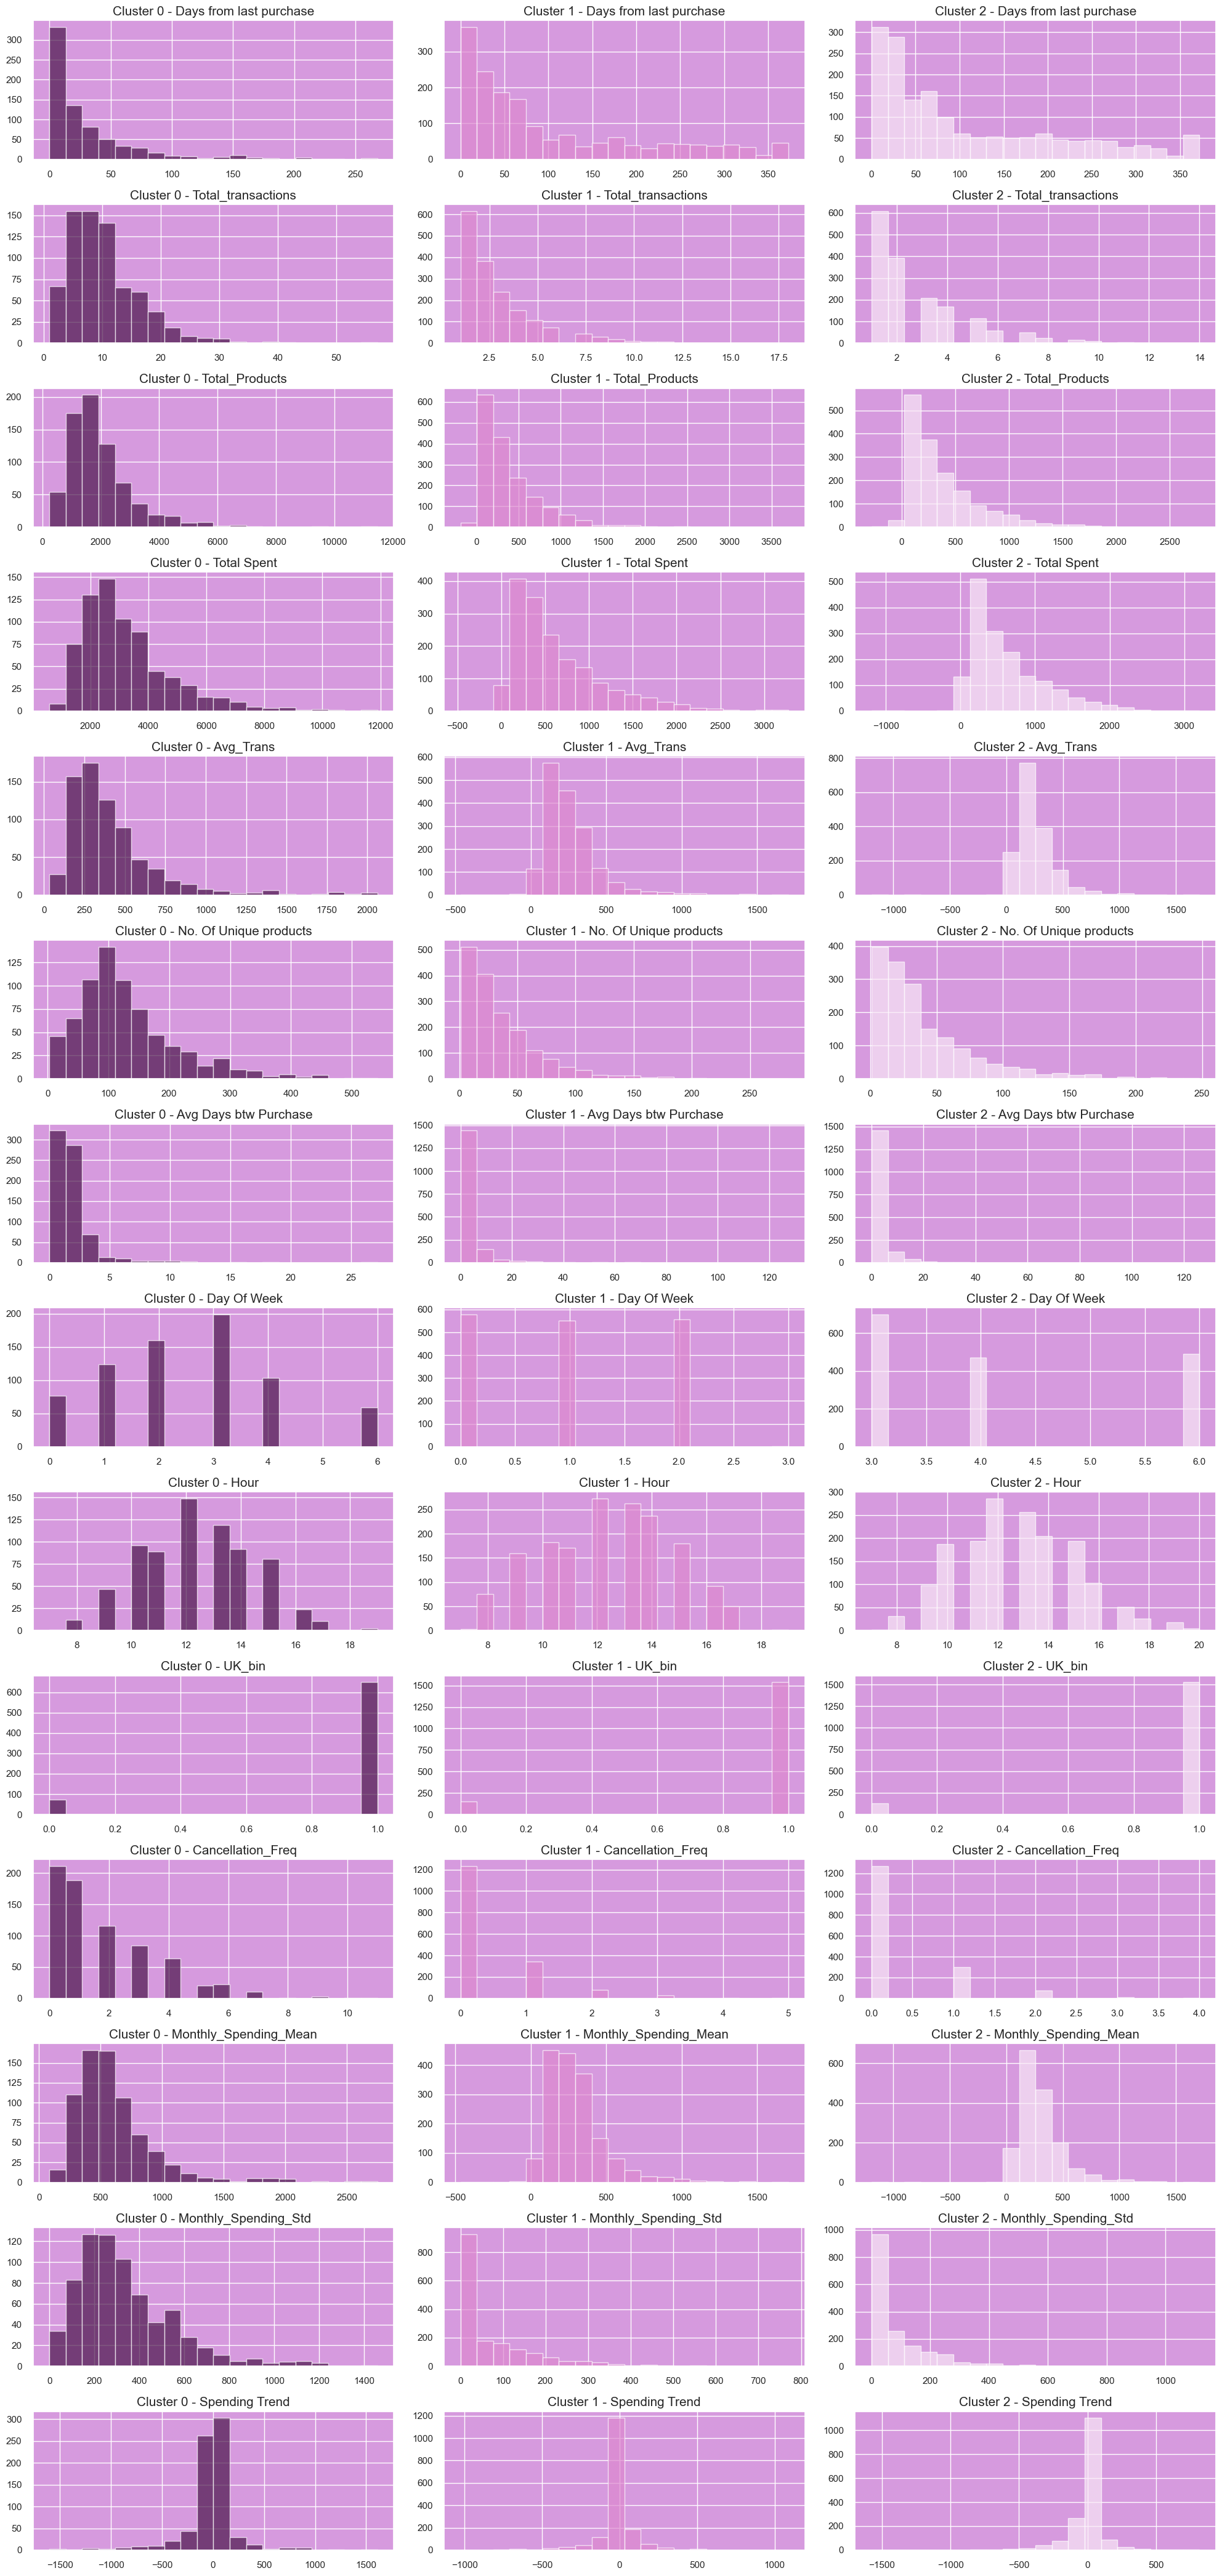

In [944]:
features = customer_recent_date_clean.columns[1:-1]
clusters = customer_recent_date_clean['cluster'].unique()
clusters.sort()

n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_recent_date_clean[customer_recent_date_clean['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

plt.tight_layout()
plt.show()